![](../images/dtlogo.png)

In [1]:
%matplotlib inline
import time
import numpy as np
import matplotlib.pyplot as plt

# Kalman filter

The Kalman filter (KF) is one of the most widely used state estimation algorithm in robotics applications. In the real world, we may already know the dynamics of the robot that allows us to know how the state of the robot evolves over time given the initial state. Unfortunately, we always have to deal with imperfect (i.e., noisy) dynamics for various reasons (e.g., imperfect parts, etc.).

Robots typically have various sensors, and we can use these sensors to also help in estimating the state of the robot. However, sensors are also not perfect and can only provide a rough estimate of the robot state. Can we combine the data from our sensors with other models (e.g., dynamics) that we already have to better estimate the robot state? This is where KF can help us. If we have new data about the state of the robot, together with a measure of how informative it is (for example an associated _covariance_), we can use this new information and combine it with what we already have to make a better estimate of our state. 

Recall that in KF, we assume:
1. Linear dynamics with Gaussian noise $\mathbf{x}_{t} = A \mathbf{x}_{t-1} + B \mathbf{u}_{t-1} + \mathbf{w}_{t}$ where $\mathbf{w}_{t} \sim \mathcal{N}(0, R)$
2. Linear measurement model with Gaussian noise $\mathbf{z}_t = H \mathbf{x}_t + \mathbf{n}_t$ where $\mathbf{n}_t \sim \mathcal{N}(0, Q)$
3. Gaussian prior $bel(\mathbf{x}_0) \sim \mathcal{N}(\mu_0, \Sigma_0)$

In the lecture videos, we have seen that there are two main steps that we need to perform: predict and update.

## Prediction step 

In the predict step we want to an obtain an estimate of $\bar{bel}(\mathbf{x}_{t}) = \mathcal{N}(\bar{\mu}_{t}, \bar{\Sigma}_{t}) $. We do this with two equations, one for our mean vector and one for our covariance matrix:

1. $\bar{\mu}_{t} = A\mu_{t-1} + B\mathbf{u}_{t}$
2. $\bar{\Sigma}_{t} = A\Sigma_{t-1}A^T + R$


## Update step

In the update step we want to obtain an estimate of $bel(\mathbf{x}_t) = \mathcal{N}(\mu_t,\Sigma_t)$. In this case we do the following steps:

1. Get measurement $\mathbf{z}_{t}$
2. Compute mean and covariance of the prediction residual $\delta_{\mu} = \mathbf{z}_{t} - H\bar{\mu}_{t}$ and $\delta_{\Sigma} = H \bar{\Sigma}_{t} H^T + Q$
3. Compute Kalman gain $K_{t} = \bar{\Sigma}_{t} H^T \delta_{\Sigma}^{-1}$
4. Compute mean and covariance of the belief $\mu_{t} = \bar{\mu}_{t} + K\delta_{\mu}$ and $\Sigma_{t} = \bar{\Sigma}_{t} - KH\bar{\Sigma}_{t}$



## Example: estimating robot position with KF 

Consider robot moving in a room without obstacles. The robot is equipped with two sensors to measure distance between the robot and the walls, which allows the robot to measure the location of the robot (i.e., $x$ and $y$ positions) in the room. These sensors are not perfect, however the manufacturer provide us with the information that tells us how innacurate these sensors are.

So, say the state of the robot is its $x$ and $y$ position in the room, and the control inputs are the velocity in each direction $v_x$ and $v_y$. The robot is initialized at $(x,y) = (0,0)$, and moves by applying constant control inputs $v_x = v_y = 1$ for 10 time steps. At each time step, after applying a control signal, the robot can take a measurement using the sensors to have an idea where the it currently is. For the sake of simplicity, assume the sensors directly return the measurement of the $(x,y)$ location in the room.

Given:

$$
A = 
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$

$$
B = 
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$

$$
Q = 
\begin{bmatrix}
0.3 & 0 \\
0 & 0.3
\end{bmatrix}
$$

$$
H = 
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$

$$
R = 
\begin{bmatrix}
0.75 & 0.0 \\
0.0 & 0.6
\end{bmatrix}
$$

Use Kalman filter to have a better estimate of where the robot is.

**Understanding the problem**

To understand the problem, let us plot the ideal trajectory and some possible measurements that we would get using the available sensors according to their specifications.

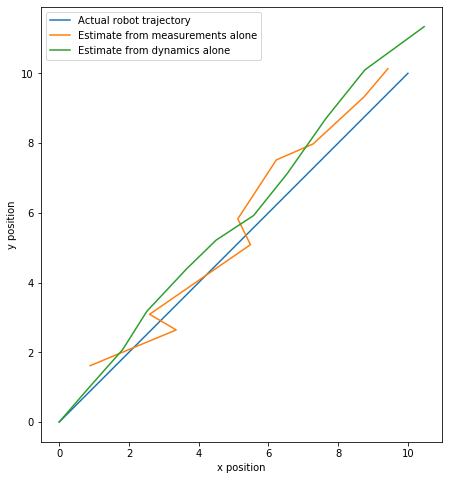

In [2]:
# state = [x_pos, y_pos]
num_data = 10
ground_truth_x = np.linspace(0, 10, num=num_data + 1)
ground_truth_y = ground_truth_x.copy() # x = y

# Simulate dynamics
x_0, y_0 = 0, 0
xs, ys = [0], [0]
dynamics_noise_x_var = 0.3
dynamics_noise_y_var = 0.3
for _ in range(10):
    v_x, v_y = 1.0, 1.0
    noise_x = np.random.normal(loc=0.0, scale=dynamics_noise_x_var)
    noise_y = np.random.normal(loc=0.0, scale=dynamics_noise_y_var)
    new_x = xs[-1] + v_x + noise_x
    new_y = ys[-1] + v_y + noise_y
    xs.append(new_x)
    ys.append(new_y)
    
# Simulate measurements
measurement_noise_x_var = 0.75
measurement_noise_y_var = 0.6
noise_x = np.random.normal(loc=0.0, scale=measurement_noise_x_var, size=num_data-1)
noise_y = np.random.normal(loc=0.0, scale=measurement_noise_y_var, size=num_data-1)
measurement_x = np.linspace(1, 10, num=num_data-1) + noise_x
measurement_y = np.linspace(1, 10, num=num_data-1) + noise_y

# Compare ground truth and measurements
plt.figure(figsize=(8,8))
plt.plot(ground_truth_x, ground_truth_y)
plt.plot(measurement_x, measurement_y)
plt.plot(xs, ys)
plt.xlabel('x position')
plt.ylabel('y position')
plt.legend(['Actual robot trajectory', 'Estimate from measurements alone', 'Estimate from dynamics alone'])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

The above plot shows the ground truth robot trajectory, as well as the estimate we get from the measurements, and the estimate that we get from the integrating forward the dynamics (known as dead reckoning). Our objective with the Kalman filter is to get a better estimate by fusing the dynamics estimate and measurements together. 

### Predict Step

Recall the prediction step (i.e., getting $\bar{bel}(\mathbf{x}_{t}) = \mathcal{N}(\bar{\mu}_{t}, \bar{\Sigma}_{t}) $):
1. $\bar{\mu}_{t} = A\mu_{t-1} + B\mathbf{u}_{t}$
2. $\bar{\Sigma}_{t} = A\Sigma_{t-1}A^T + R$

In [3]:
def predict(A, B, Q, mu_t, u_t, Sigma_t):
    predicted_mu = A @ mu_t + B @ u_t
    predicted_Sigma = A @ Sigma_t @ A.T + Q
    return predicted_mu, predicted_Sigma

### Update step

Recall the update step:
1. Get measurement $\mathbf{z}_{t}$
2. Compute mean and covariance of the prediction residual $\delta_{\mu} = \mathbf{z}_{t} - H\bar{\mu}_{t}$ and $\delta_{\Sigma} = H \bar{\Sigma}_{t} H^T + Q$
3. Compute Kalman gain $K_{t} = \bar{\Sigma}_{t} H^T \delta_{\Sigma}^{-1}$
4. Compute mean and covariance of the belief $\mu_{t} = \bar{\mu}_{t} + K\delta_{\mu}$ and $\Sigma_{t} = \bar{\Sigma}_{t} - KH\bar{\Sigma}_{t}$

In [4]:
def update(H, R, z, predicted_mu, predicted_Sigma):
    residual_mean = z - H @ predicted_mu
    residual_covariance = H @ predicted_Sigma @ H.T + R
    kalman_gain = predicted_Sigma @ H.T @ np.linalg.inv(residual_covariance)
    updated_mu = predicted_mu + kalman_gain @ residual_mean
    updated_Sigma = predicted_Sigma - kalman_gain @ H @ predicted_Sigma
    return updated_mu, updated_Sigma

Let's run our Kalman filter!

In [5]:
# Initialize the problem
mu_0 = np.array([0, 0])
Sigma_0 = np.array([[0.1, 0],
                     [0, 0.1]]) # We're pretty certain about bel_0
A = np.array([[1, 0],
              [0, 1]])
B = np.array([[1, 0],
              [0, 1]])
Q = np.array([[0.3, 0],
              [0, 0.3]])
H = np.array([[1, 0],
              [0, 1]])
R = np.array([[measurement_noise_x_var, 0],
              [0, measurement_noise_y_var]])

# Initialize empty lists for mus and measurements for plotting
measurements = []
filtered_mus = []

# Run KF for each time step
mu_current = mu_0.copy()
Sigma_current = Sigma_0.copy()
for i in range(num_data-1):
    u_t = np.array([1, 1])
    
    # Predict step
    predicted_mu, predicted_Sigma = predict(A, B, Q, 
                                            mu_current, u_t, 
                                            Sigma_current)
    
    # Get measurement (irl, get this from our sensor)
    measurement_noise_x = np.random.normal(loc=0.0, scale=measurement_noise_x_var)
    measurement_noise_y = np.random.normal(loc=0.0, scale=measurement_noise_y_var)
    measurement_x_new = ground_truth_x[i+1] + measurement_noise_x
    measurement_y_new = ground_truth_x[i+1] + measurement_noise_y
    z = np.array([measurement_x_new, measurement_y_new])
    
    # The rest of update step
    mu_current, Sigma_current = update(H, R, z, 
                                   predicted_mu, 
                                   predicted_Sigma)
    
    # Store measurements and mu_current so we can plot it later
    measurements.append([measurement_x_new, measurement_y_new])
    filtered_mus.append(mu_current)

# Just for plotting purposes, convert the lists to array 
measurements = np.array(measurements)
filtered_mus = np.array(filtered_mus) 

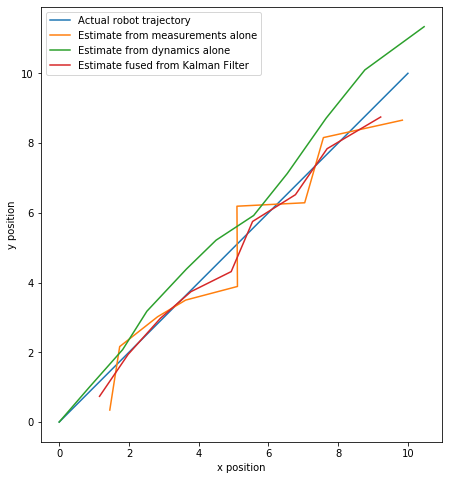

In [6]:
# Let's plot the results

plt.figure(figsize=(8,8))
plt.plot(ground_truth_x, ground_truth_y)
plt.plot(measurements[:,0], measurements[:,1])
plt.plot(xs, ys)
plt.plot(filtered_mus[:,0], filtered_mus[:,1])
plt.xlabel('x position')
plt.ylabel('y position')
plt.legend(['Actual robot trajectory', 'Estimate from measurements alone', 'Estimate from dynamics alone', 'Estimate fused from Kalman Filter'])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

We can see that the KF is able to fuse all of the information together and give us a better final estimate of the robot trajectory.